# **NT522.P21.ANTT - Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình GRU**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình GRU để phát hiện xâm nhập mạng.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

C:\Users\WanThinnn\.keras\datasets\kddcup.data_10_percent.gz


In [3]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [4]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [5]:
df.shape

(494021, 42)

In [6]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [7]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [8]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [9]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [10]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\2862700925.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\2862700925.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\2862700925.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

In [11]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [12]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [13]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [14]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [16]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình GRU**

In [17]:
model = keras.Sequential()
model.add(keras.layers.GRU(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\WanThinnn\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

## **5. Huấn luyện mô hình**

In [18]:
history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - accuracy: 0.7932 - loss: 0.5397 - val_accuracy: 0.8031 - val_loss: 0.4769
Epoch 2/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 58s 213ms/step - accuracy: 0.8291 - loss: 0.4254 - val_accuracy: 0.9374 - val_loss: 0.2346


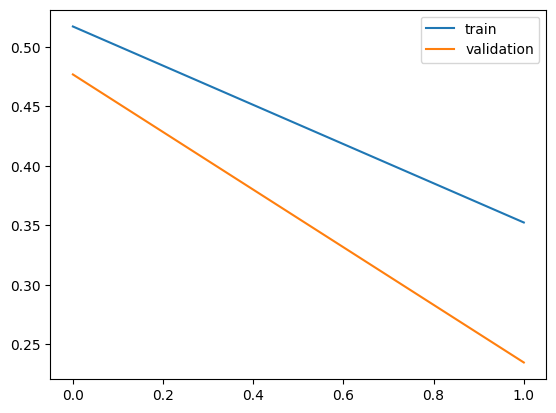

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

## **6. Đánh giá mô hình**

In [20]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9373 - loss: 0.2341


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IoT dataset 2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





In [21]:
# Đọc lại dữ liệu KDD99 cho phân loại đa lớp
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

df_multi = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df_multi)))

# Đặt tên cột
df_multi.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

Read 494021 rows.


In [22]:
# Kiểm tra các loại attack
print("Các loại attack trong dataset:")
print(df_multi['outcome'].value_counts())
print(f"\nTổng số loại attack: {df_multi['outcome'].nunique()}")

Các loại attack trong dataset:
outcome
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

Tổng số loại attack: 23


In [23]:
# Xử lý dữ liệu thiếu
df_multi.dropna(inplace=True, axis=1)
print(f"Shape sau khi xử lý NA: {df_multi.shape}")

Shape sau khi xử lý NA: (494021, 42)


In [24]:
### **2. Encode dữ liệu cho phân loại đa lớp**

# Sử dụng lại các hàm encode từ phần A
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encoding features (giữ nguyên outcome để xử lý riêng)
text_col = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

for i in df_multi.columns:
    if i not in text_col:
        if i != 'outcome':
            encode_numeric_zscore(df_multi, i)

for x in text_col:
    encode_text_dummy(df_multi, x)

df_multi.dropna(inplace=True, axis=1)
print(f"Shape sau khi encode: {df_multi.shape}")

C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\3047980763.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\3047980763.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\WanThinnn\AppData\Local\Temp\ipykernel_26232\3047980763.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

Shape sau khi encode: (494021, 121)


In [ ]:
### **3. Chuẩn bị nhãn cho phân loại đa lớp**

# Encode nhãn thành số
label_encoder = LabelEncoder()
y_multi = label_encoder.fit_transform(df_multi['outcome'])

print("Mapping các loại attack:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

print(f"\nSố lượng lớp: {len(label_encoder.classes_)}")

# Tách features và target
X_multi = df_multi.drop('outcome', axis=1)

Mapping các loại attack:
0: back.
1: buffer_overflow.
2: ftp_write.
3: guess_passwd.
4: imap.
5: ipsweep.
6: land.
7: loadmodule.
8: multihop.
9: neptune.
10: nmap.
11: normal.
12: perl.
13: phf.
14: pod.
15: portsweep.
16: rootkit.
17: satan.
18: smurf.
19: spy.
20: teardrop.
21: warezclient.
22: warezmaster.

Số lượng lớp: 23


In [26]:
# Chia dữ liệu train/test
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=12, stratify=y_multi
)

print(f"Training set: {X_train_multi.shape}, {y_train_multi.shape}")
print(f"Test set: {X_test_multi.shape}, {y_test_multi.shape}")

# One-hot encoding cho target
num_classes = len(label_encoder.classes_)
y_train_multi_onehot = tf.one_hot(y_train_multi, num_classes)
y_test_multi_onehot = tf.one_hot(y_test_multi, num_classes)

print(f"Số lượng lớp: {num_classes}")

Training set: (345814, 120), (345814,)
Test set: (148207, 120), (148207,)
Số lượng lớp: 23


In [27]:
### **4. Kiến trúc mô hình GRU cho phân loại đa lớp**

model_multi = keras.Sequential([
    keras.layers.GRU(units=64, input_shape=(X_train_multi.shape[1], 1)),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(units=num_classes, activation='softmax')  # Softmax cho multiclass
])

# Compile model với categorical crossentropy
model_multi.compile(
    loss='categorical_crossentropy',  # Thay đổi loss function
    optimizer='adam',
    metrics=['accuracy']
)

model_multi.summary()

C:\Users\WanThinnn\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,151 (94.34 KB)

 Trainable params: 24,151 (94.34 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
### **5. Huấn luyện mô hình đa lớp**

history_multi = model_multi.fit(
    X_train_multi, y_train_multi_onehot,
    epochs=10,
    batch_size=1024,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - accuracy: 0.5224 - loss: 1.6345 - val_accuracy: 0.7759 - val_loss: 0.8076
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 69s 256ms/step - accuracy: 0.8737 - loss: 0.4561 - val_accuracy: 0.8043 - val_loss: 0.5266
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 57s 208ms/step - accuracy: 0.8731 - loss: 0.4951 - val_accuracy: 0.9272 - val_loss: 0.3240
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 52s 190ms/step - accuracy: 0.9225 - loss: 0.3532 - val_accuracy: 0.9273 - val_loss: 0.3093
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - accuracy: 0.9228 - loss: 0.3334 - val_accuracy: 0.9274 - val_loss: 0.3014
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 58s 215ms/step - accuracy: 0.9237 - loss: 0.3218 - val_accuracy: 0.9268 - val_loss: 0.2900
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 65s 238ms/step - accuracy: 0.9287 - loss: 0.2972 - val_accuracy: 0.9635 - val_loss: 0.1732
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 61s 226ms/step - accuracy: 0.9655 - loss: 0

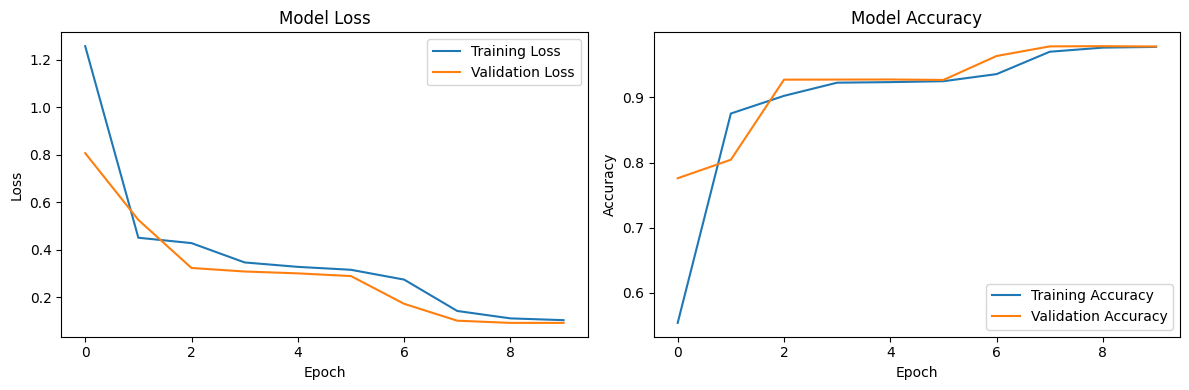

In [29]:
### **6. Visualize training history**

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_multi.history['loss'], label='Training Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multi.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
### **7. Đánh giá mô hình đa lớp**

# Đánh giá trên tập test
test_loss, test_accuracy = model_multi.evaluate(X_test_multi, y_test_multi_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Dự đoán
y_pred_multi = model_multi.predict(X_test_multi)
y_pred_classes = np.argmax(y_pred_multi, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_classes, 
                          target_names=label_encoder.classes_))

Test Loss: 0.0946
Test Accuracy: 0.9778
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step

Classification Report:
                  precision    recall  f1-score   support

           back.       0.00      0.00      0.00       661
buffer_overflow.       0.00      0.00      0.00         9
      ftp_write.       0.00      0.00      0.00         2
   guess_passwd.       0.00      0.00      0.00        16
           imap.       0.00      0.00      0.00         4
        ipsweep.       0.00      0.00      0.00       374
           land.       0.00      0.00      0.00         6
     loadmodule.       0.00      0.00      0.00         3
       multihop.       0.00      0.00      0.00         2
        neptune.       0.98      0.99      0.99     32160
           nmap.       0.00      0.00      0.00        69
         normal.       0.92      0.99      0.95     29184
           perl.       0.00      0.00      0.00         1
            phf.       0.00      0.00      0.00         1
            pod.    

C:\Users\WanThinnn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\WanThinnn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\WanThinnn\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

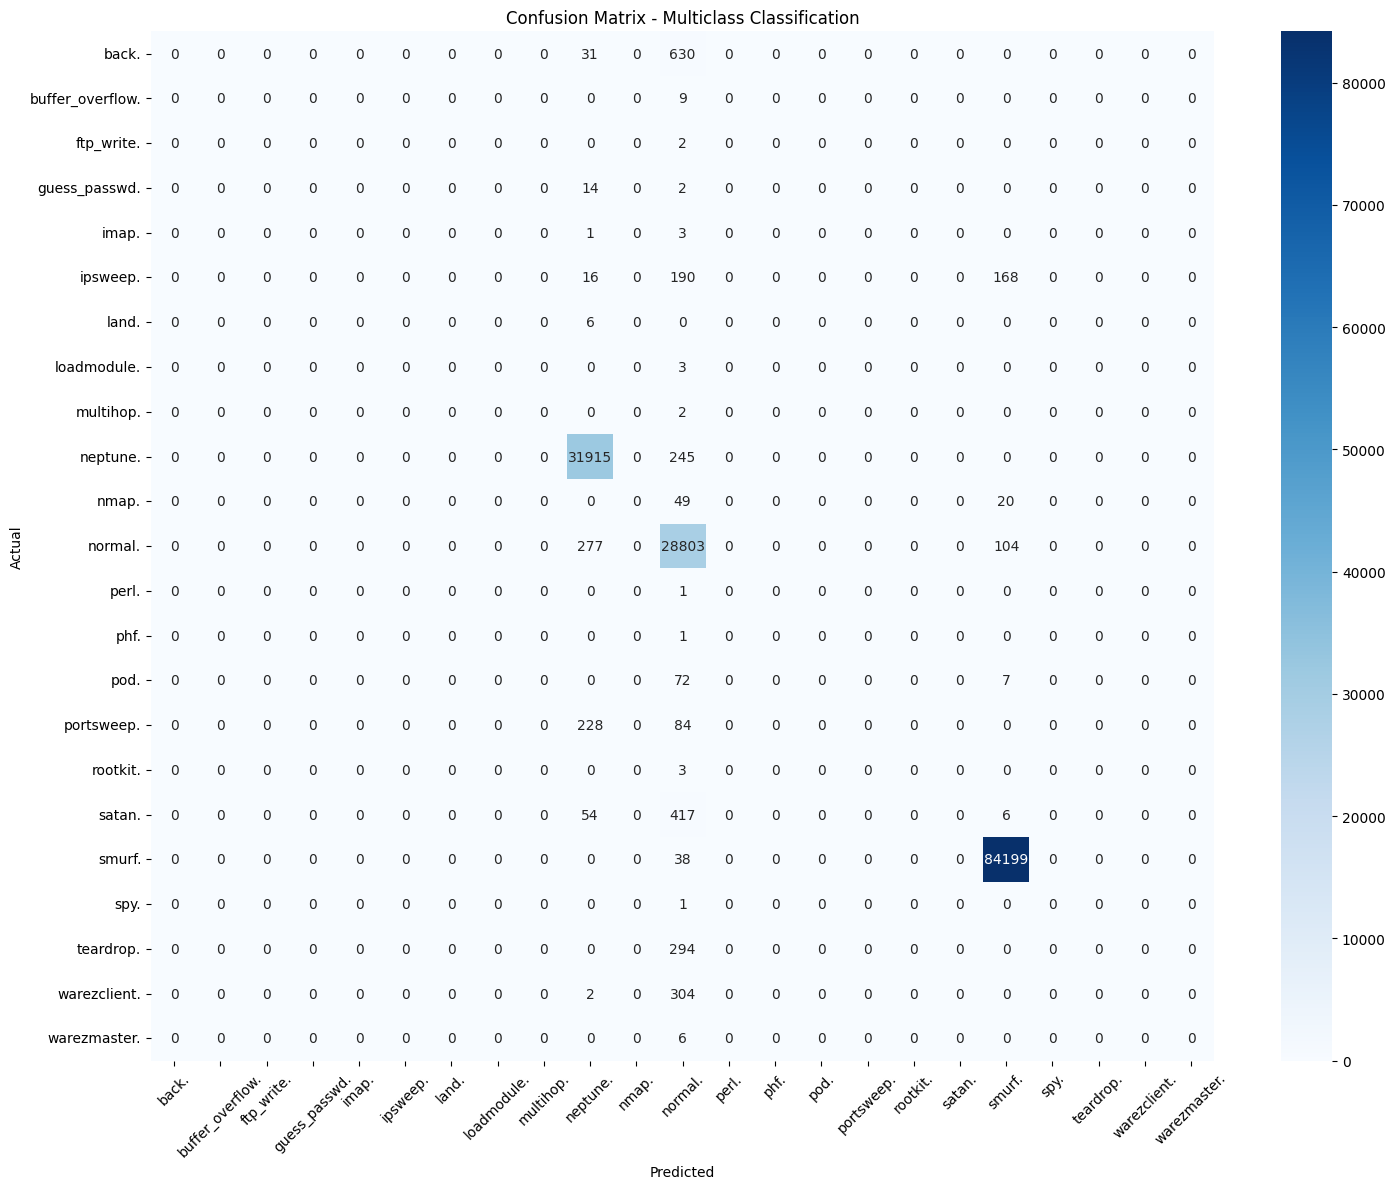

In [31]:
### **8. Confusion Matrix**

plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test_multi, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Multiclass Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
### **9. So sánh hiệu suất các lớp**

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test_multi, y_pred_classes, average=None
)

results_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("Hiệu suất theo từng lớp:")
print(results_df.round(4))

# Macro và weighted averages
macro_avg = precision_recall_fscore_support(y_test_multi, y_pred_classes, average='macro')
weighted_avg = precision_recall_fscore_support(y_test_multi, y_pred_classes, average='weighted')

print(f"\nMacro Average - Precision: {macro_avg[0]:.4f}, Recall: {macro_avg[1]:.4f}, F1: {macro_avg[2]:.4f}")
print(f"Weighted Average - Precision: {weighted_avg[0]:.4f}, Recall: {weighted_avg[1]:.4f}, F1: {weighted_avg[2]:.4f}")